# Image-captioning 

- gen the description of the image by using encoder-decoder model.

- Dataset : -> Flickr8K.

- Data-preprocesing : Need to create the vocab for text data and then into nums.(for image same as before).

- Model : -> Encoder : -> CNN(Resnet50) and BahdanauAttention + Decoder(LSTMs).


# Data 

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
#imports 
import pandas as pd
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transform 
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from PIL import Image



In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd

class ImageCaptionDataset(Dataset):
    def __init__(self, root_dir, captions_file, tokenizer, transform=None):
        self.root_dir = root_dir
        self.captions_file = pd.read_csv(captions_file)
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.captions_file)

    def __getitem__(self, idx):
        img_name = self.captions_file.iloc[idx, 0]
        caption = self.captions_file.iloc[idx, 1]

        img_path = f"{self.root_dir}/{img_name}"
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        # Tokenize the caption
        caption_tokens = self.tokenizer(caption, padding='max_length', max_length=30, truncation=True, return_tensors="pt")
        caption_tensor = caption_tokens['input_ids'].squeeze()  # Remove extra dimension

        return image, caption_tensor



In [4]:
def custom_collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, dim=0)
    captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=0)
    return images, captions


In [5]:
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from transformers import BertTokenizer

# Define your tokenizer (using BERT tokenizer as an example)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define your transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# dataset
root_dir = '/kaggle/input/flickr8k/Images'
captions_file = '/kaggle/input/flickr8k/captions.txt'
dataset = ImageCaptionDataset(root_dir=root_dir, captions_file=captions_file, tokenizer=tokenizer, transform=transform)

# a subset of the dataset with 5000 samples
subset_indices = list(range(6000))
subset = Subset(dataset, subset_indices)

train_size = int(0.8 * len(subset_indices))
test_size = len(subset_indices) - train_size

train_indices, test_indices = train_test_split(subset_indices, train_size=train_size, test_size=test_size, random_state=42)

train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

torch.Size([32, 3, 224, 224]) torch.Size([32, 30])


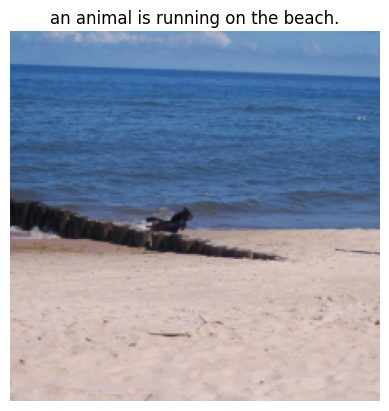

In [6]:
def visualize_image_with_caption(image, caption_tensor, tokenizer):
    # Convert tensor to numpy array for visualization
    image_np = image.squeeze(0).permute(1, 2, 0).numpy()
    image_np = np.clip(image_np, 0, 1)  # Ensure values are in [0, 1] range

    # Decode the caption tensor to get the caption text
    caption_text = tokenizer.decode(caption_tensor.squeeze(), skip_special_tokens=True)
    
    # Plot the image with its caption
    plt.imshow(image_np)
    plt.title(caption_text)
    plt.axis('off')
    plt.show()

# Example: Visualize a single image with its corresponding caption
for images, captions in train_loader:
    visualize_image_with_caption(images[0], captions[0], tokenizer)
    break  # Remove this break to visualize more images

# Model 

The model consists two imp blocks i.e encoder and decoder.

### Encoder :


### Decoder : 

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from transformers import BertTokenizer

class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.attention_dim = attention_dim
        self.W = nn.Linear(decoder_dim, attention_dim)
        self.U = nn.Linear(encoder_dim, attention_dim)
        self.A = nn.Linear(attention_dim, 1)
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     
        w_ah = self.W(hidden_state) 
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) 
        attention_scores = self.A(combined_states)        
        attention_scores = attention_scores.squeeze(2)    
        alpha = F.softmax(attention_scores, dim=1)    #attention_weight      
        attention_weights = features * alpha.unsqueeze(2)  
        attention_weights = attention_weights.sum(dim=1)  
        return alpha, attention_weights

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(len(BertTokenizer.from_pretrained('bert-base-uncased')), embed_size)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)
        self.fcn = nn.Linear(decoder_dim, self.embedding.num_embeddings)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        embeds = self.embedding(captions)
        h, c = self.init_hidden_state(features)
        seq_length = captions.size(1) - 1 
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.embedding.num_embeddings).to(features.device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(features.device)
                
        for s in range(seq_length):
            alpha, context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            preds[:, s] = output
            alphas[:, s] = alpha  
        
        return preds, alphas
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  
        c = self.init_c(mean_encoder_out)
        return h, c

class EncoderDecoder(nn.Module):
    def __init__(self, embed_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim,
            drop_prob=drop_prob
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs, alphas = self.decoder(features, captions)
        return outputs, alphas


# Training 

In [17]:
#Hyperparams
embed_size=300
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [13]:

from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Initialize the model
model = EncoderDecoder(
    embed_size=300,
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

# Initialize criterion and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


In [14]:

import torch
from torch.nn.parallel import DataParallel
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

def train(model, train_loader, test_loader, criterion, optimizer, num_epochs, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # multiple GPUs support
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = DataParallel(model)
    
    # Initialize the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    
    print_every = 150
    
    # Create a directory to store checkpoints
    os.makedirs('checkpoints', exist_ok=True)
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for idx, (image, captions) in enumerate(train_loader):
            image, captions = image.to(device), captions.to(device)
            
            optimizer.zero_grad()
            
            outputs, _ = model(image, captions)
            targets = captions[:, 1:]  # shifted target for teacher forcing
            loss = criterion(outputs.view(-1, tokenizer.vocab_size), targets.reshape(-1))
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # calculating accuracy, ignoring padding index
            _, predicted = outputs.max(2)
            mask = targets != tokenizer.pad_token_id
            correct_predictions += (predicted == targets).masked_select(mask).sum().item()
            total_predictions += mask.sum().item()
            
            if (idx + 1) % print_every == 0:
                avg_loss = running_loss / print_every
                accuracy = correct_predictions / total_predictions
                print(f"Epoch: {epoch}/{num_epochs}, Batch: {idx+1}/{len(train_loader)}, Loss: {avg_loss:.5f}, Accuracy: {accuracy:.5f}")
                running_loss = 0.0
                correct_predictions = 0
                total_predictions = 0
        
        # evaluate the model on the test set
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.inference_mode():
            for image, captions in test_loader:
                image, captions = image.to(device), captions.to(device)
                outputs, _ = model(image, captions)
                targets = captions[:, 1:]
                loss = criterion(outputs.view(-1, tokenizer.vocab_size), targets.reshape(-1))
                test_loss += loss.item()
                
                _, predicted = outputs.max(2)
                mask = targets != tokenizer.pad_token_id
                test_correct += (predicted == targets).masked_select(mask).sum().item()
                test_total += mask.sum().item()
        
        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = test_correct / test_total
        print(f"Epoch: {epoch}/{num_epochs}, Test Loss: {avg_test_loss:.5f}, Test Accuracy: {test_accuracy:.5f}")
        
        # Step the scheduler
        scheduler.step(avg_test_loss)
        
        # Save model weights at every epoch
        if isinstance(model, DataParallel):
            torch.save(model.module.state_dict(), f"checkpoints/model_weights_epoch_{epoch}.pth")
        else:
            torch.save(model.state_dict(), f"checkpoints/model_weights_epoch_{epoch}.pth")
        print(f"Model weights saved for epoch {epoch}")


In [19]:
# Train the model
num_epochs = 100
train(model, train_loader, test_loader, criterion, optimizer, num_epochs, tokenizer)

Using 2 GPUs
Epoch: 1/100, Batch: 10/32, Loss: 5.09127, Accuracy: 0.16671
Epoch: 1/100, Batch: 20/32, Loss: 4.96058, Accuracy: 0.19623
Epoch: 1/100, Batch: 30/32, Loss: 4.90241, Accuracy: 0.21061
Epoch: 1/100, Validation Loss: 4.73212, Validation Accuracy: 0.22848
Model saved at epoch 1
Epoch: 2/100, Batch: 10/32, Loss: 4.76343, Accuracy: 0.21695
Epoch: 2/100, Batch: 20/32, Loss: 4.66704, Accuracy: 0.22703
Epoch: 2/100, Batch: 30/32, Loss: 4.68473, Accuracy: 0.24842
Epoch: 2/100, Validation Loss: 4.50250, Validation Accuracy: 0.25578
Model saved at epoch 2
Epoch: 3/100, Batch: 10/32, Loss: 4.55245, Accuracy: 0.25647
Epoch: 3/100, Batch: 20/32, Loss: 4.45422, Accuracy: 0.26161
Epoch: 3/100, Batch: 30/32, Loss: 4.55525, Accuracy: 0.25936
Epoch: 3/100, Validation Loss: 4.33480, Validation Accuracy: 0.27719
Model saved at epoch 3
Epoch: 4/100, Batch: 10/32, Loss: 4.33117, Accuracy: 0.27069
Epoch: 4/100, Batch: 20/32, Loss: 4.29731, Accuracy: 0.28508
Epoch: 4/100, Batch: 30/32, Loss: 4.3892

In [28]:
checkpoint = torch.load("/kaggle/working/good_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [29]:
print(model)

EncoderDecoder(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

In [31]:
torch.save(model.state_dict(), "model_weights.pth")

# Inference 

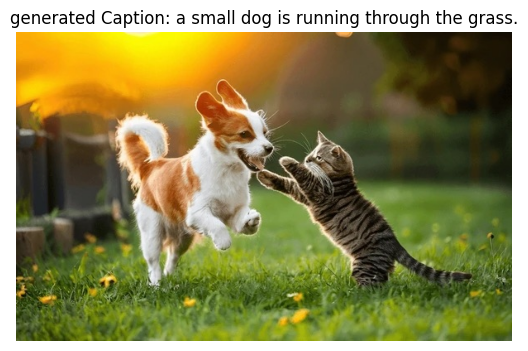

In [40]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize the model
embed_size = 300
vocab_size = tokenizer.vocab_size  # Using tokenizer's vocab size
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512
drop_prob = 0.3

model = EncoderDecoder(
    embed_size=embed_size,
    
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim,
    drop_prob=drop_prob
).to(device)

# Load the pre-trained model weights
model.load_state_dict(torch.load("/kaggle/working/model_weights.pth", map_location=device))
model.eval()

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def predict_caption(image_path, model, tokenizer, max_len=50):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Encode the image
    features = model.encoder(image_tensor)
    
    # Initialize the hidden and cell states
    h, c = model.decoder.init_hidden_state(features)
    
    # Start the caption with the [CLS] token
    word = torch.tensor([tokenizer.cls_token_id]).to(device)
    embeds = model.decoder.embedding(word)
    
    captions = []
    alphas = []
    
    for _ in range(max_len):
        alpha, context = model.decoder.attention(features, h)
        alphas.append(alpha.cpu().detach().numpy())
        
        lstm_input = torch.cat((embeds.squeeze(1), context), dim=1)
        h, c = model.decoder.lstm_cell(lstm_input, (h, c))
        
        output = model.decoder.fcn(model.decoder.drop(h))
        predicted_word_idx = output.argmax(dim=1)
        
        captions.append(predicted_word_idx.item())
        
        # Break if [SEP] token is generated
        if predicted_word_idx.item() == tokenizer.sep_token_id:
            break
        
        embeds = model.decoder.embedding(predicted_word_idx.unsqueeze(0))
    
    # Convert word indices to words, skipping special tokens
    caption = tokenizer.decode(captions, skip_special_tokens=True)
    return image, caption

# Test the inference and display the image with caption
image_path = "/kaggle/input/cat-data/heartwarming-moment-between-dog-cat-600nw-2432338827.jpg" 
image, caption = predict_caption(image_path, model, tokenizer)

# Display the image with the generated caption
plt.imshow(image)
plt.title("generated Caption: " + caption)
plt.axis("off")
plt.show()
